# Predicción de la demanda energica horaria en California

**Caso a estudiar**: Estudiaremos la demanda energica en California, establecida en una frecuencia horaria, para obtener una predicción de los **7 primeros días de diciembre 2021**.

California es el estado con el mercado mas grande de los Estados Unidos, cuenta con un PIB de 2.656.080 millones de dolares, y una producción de energía de 1.844.000 millones de megawatts.

El PIB de California representa el 14% del PIB de los Estados Unidos, y el PIB de los Estados Unidos representa el 24% mundial.


### Importamos librerias

In [178]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sktime.utils.plotting import plot_series
from sktime.utils.plotting import plot_correlations
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.ets import AutoETS
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import MeanSquaredError
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score

from kats.models.prophet import Prophet

Importamos los datos y nos quedamos con los datos necesarios para el análisis.

In [179]:
df_demand = pd.read_excel('DemandaEnergia.xlsx', sheet_name='Hourly_Data')
df_hour = df_demand.drop(['Region', 'UTC time', 'Local date', 'Local hour', 'Time zone'], axis=1)

df_hour.rename(columns={'D': 'Demand', 'Local time': 'Local_time'}, inplace=True)
df_hour.set_index('Local_time', inplace=True)

df_hour.index = pd.PeriodIndex(df_hour.index, freq='H')
df_hour_complete = df_hour.copy()
df_hour

,Demand
Local_time,
2015-07-01 01:00,38210
2015-07-01 02:00,35171
2015-07-01 03:00,33243
2015-07-01 04:00,31955
2015-07-01 05:00,31199
...,...
2021-11-30 11:00,29068
2021-11-30 12:00,28769
2021-11-30 13:00,29180


Text(0.5, 1.0, 'Demanda electrica horaria')

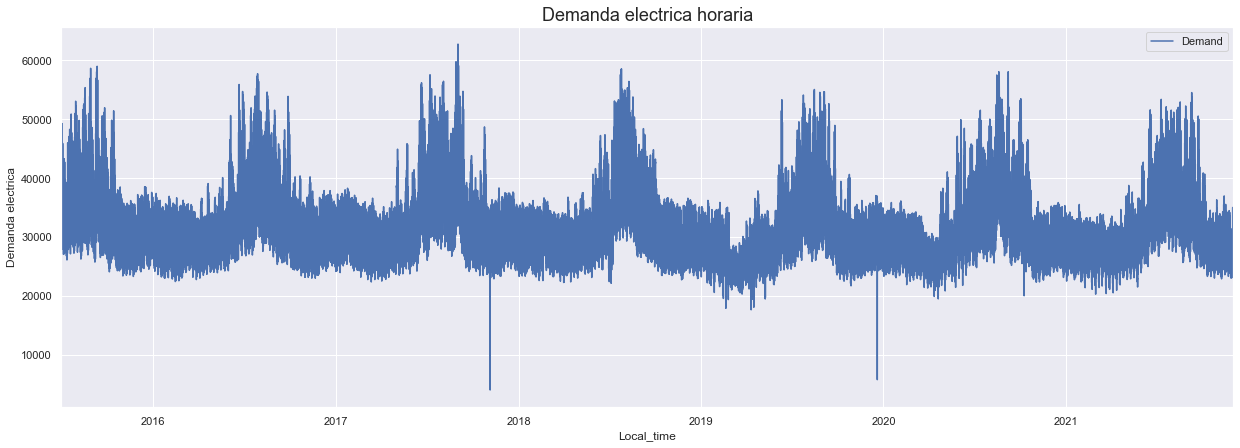

In [180]:
sns.set(rc={'figure.figsize':(21, 7)})
ax = df_hour.plot(linestyle='-')
ax.set_ylabel('Demanda electrica')
ax.set_title('Demanda electrica horaria', fontsize=18)

El grafico nos muestra que tenemos dos outliers muy significativos al final del año 2017 y al final del 2019, pero como vamos a trabajar en una predicción horaria, no vamos a utilizar esos datos para el entrenamiento del modelo por lo que los dejamos pasar.


## EDA: Análisis exploratorio de los datos

Graficamos la serie recortada que utilizaremos para el modelado para ver como se comporta.

Text(0.5, 1.0, 'Demanda electrica por dia')

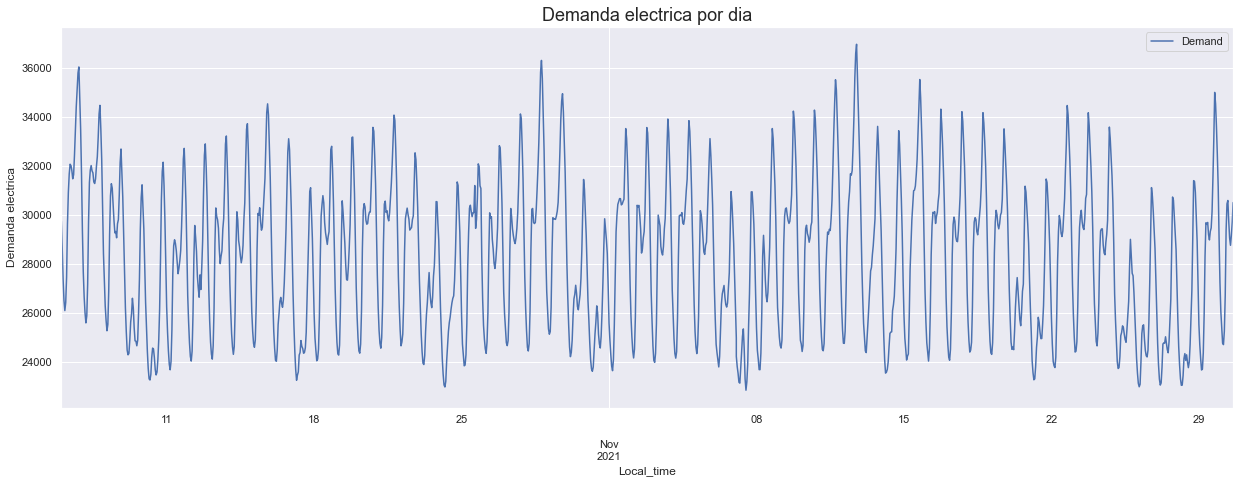

In [181]:
sns.set(rc={'figure.figsize':(21, 7)})
ax = df_hour['2021-10-06':].plot(linestyle='-')
ax.set_ylabel('Demanda electrica')
ax.set_title('Demanda electrica por dia', fontsize=18)

Ahora vamos a ver como se comporta la serie en diferentes periodos de tiempo.

Text(0.5, 0.98, '')

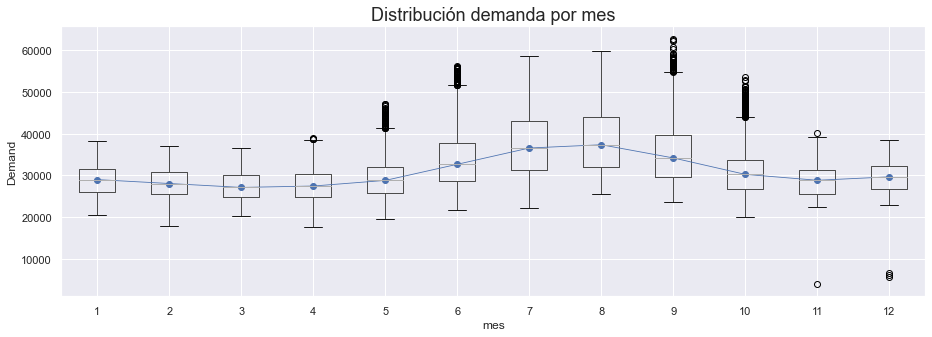

In [182]:
boxplot_month = df_hour.copy()

fig, ax = plt.subplots(figsize=(15, 5))
boxplot_month['mes'] = boxplot_month.index.month
boxplot_month.boxplot(column='Demand', by='mes', ax=ax,)
boxplot_month.groupby('mes')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Distribución demanda por mes', fontsize=18)
fig.suptitle('')

Observamos que hay un aumento de la demanda en los meses de verano que tiene su pico en el mes de agosto, en cuanto llegan los meses de frio se vuelve a disminuir la demanda es decir, de octubre a mayo.

Text(0.5, 1.0, 'Distribución demanda por día de la semana')

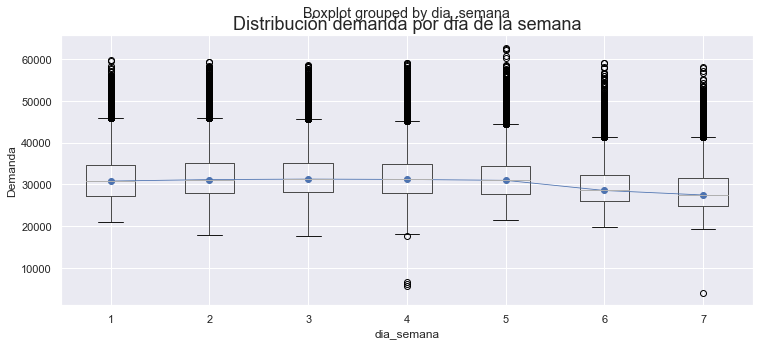

In [221]:
boxplot_week = df_hour.copy()

fig, ax = plt.subplots(figsize=(12, 5))
boxplot_week['dia_semana'] = boxplot_week.index.day_of_week + 1
boxplot_week.boxplot(column='Demand', by='dia_semana', ax=ax)
boxplot_week.groupby('dia_semana')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demanda')
ax.set_title('Distribución demanda por día de la semana' , fontsize=18)

Apreciamos una menor demanda cuando es fin de semana en comparación con los días laborables. Sin embargo, la demanda parece constante a lo largo de la semana, son valores muy parecidos.

Text(0.5, 1.0, 'Distribución demanda por hora del día')

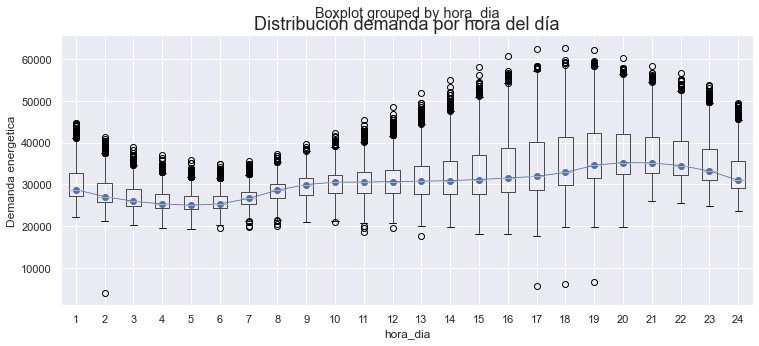

In [184]:
boxplot_day = df_hour.copy()

fig, ax = plt.subplots(figsize=(12, 5))
boxplot_day['hora_dia'] = boxplot_day.index.hour + 1
boxplot_day.boxplot(column='Demand', by='hora_dia', ax=ax)
boxplot_day.groupby('hora_dia')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demanda energetica')
ax.set_title('Distribución demanda por hora del día', fontsize=18)

Este grafico nos muestra el aumento progresivo a lo largo de las horas del dia y como empieza disminuir la demanda en la noche.

### Estacionariedad (Dickey-Fuller)

Usamos la prueba de Dickey-Fuller que nos proporciona una verificación rápida y evidente de si la serie es estacional o no.

**La hipótesis nula** (**H0**) de la prueba es que la serie temporal se puede representar mediante una raíz unitaria, que no es estacionaria (tiene alguna estructura dependiente del tiempo). **La hipótesis alternativa** (**H1**) (rechazando la hipótesis nula) es que la serie de tiempo es estacionaria.

Interpretamos este resultado utilizando el **p-value**. Un valor p por debajo del umbral de significancia (0.05) significa que la hipótesis nula se rechaza. 

In [185]:
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(df_hour)

Results of Dickey-Fuller Test:
Test Statistic                -1.008281e+01
p-value                        1.176353e-17
#Lags Used                     5.800000e+01
Number of Observations Used    5.621300e+04
Critical Value (1%)           -3.430466e+00
Critical Value (5%)           -2.861591e+00
Critical Value (10%)          -2.566797e+00
dtype: float64


La serie temporal es estacionaria, debido a que el p-value del test Dickey-Fuller es menor que 0.05. **Rechazamos la hipotesis nula (H0)**.

Comprobamos los datos duplicados y datos nulos. En este caso solo podemos comprobar los datos duplicados en el indice ya que, tenemos una cantidad enorme de datos de demada, lo que haremos será quedarnos con el primer valor de cada duplicado.

In [186]:
print(df_hour.index.duplicated().sum())
print(df_hour.isnull().sum())

7
Demand    0
dtype: int64


In [187]:
df_hour = df_hour[~df_hour.index.duplicated(keep='first')]

## Modelado

### Separamos la serie en train y test

Haremos una evaluacion de los posibles modelos a utilizar mediante muestras de entrenamiento y prueba, para comprobar qué módelo es el que mejor predice nuestro set de prueba. Una vez escojamos el modelo con mejores resultados, haremos la predicción de los 15 dias de Diciembre.

El periodo de entrenamiento tendrá una longitud de 21 dias, desde el dia 1 de noviembre hasta el dia 23 de octubre. Sin embargo, el periodo de prueba será de 7 dias, un 23% de la longitud de la serie de entrenamiento.

544 168


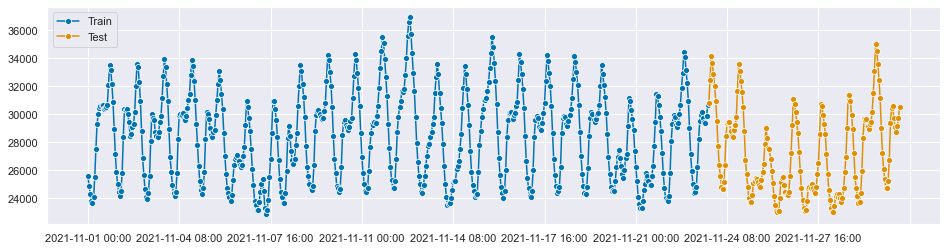

In [188]:
period_train = df_hour.loc['2021-11-01 ':]

# Select Train & test samples
y_train, y_test = temporal_train_test_split(y=period_train, test_size=168)

plot_series(y_train['2021-11-01':], y_test, labels=["Train", "Test"])
# Time Series Size
print(y_train.shape[0], y_test.shape[0])

### Modelo base ingenuo (Naïve) estacional

Uno de los modelos mas simples y mas importantes en el pronostico de series temporales es del Random Walk. Supone que para cada periodo la variable dará un paso aleatorio y los pasos se distribuyen de forma independiente e identica. En otras palabras, predice que todos los valores serán iguales a la última observación. 

Este sería el metodo Naive ingenuo, sin embargo nuestra serie temporal tiene un componente estacional, por lo que usaremos un modelo parecido añadiendole la estacionalidad dictada por la serie. Por lo tanto, en vez de predecir el ultimo valor observado, replicará la última estación observada. 

En nuestro caso, tenemos una serie diaria que para cada nuevo periodo, replicará el valor del último día.

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

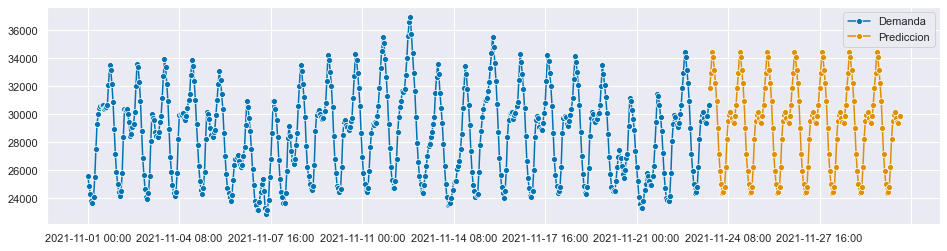

In [189]:
from sktime.forecasting.naive import NaiveForecaster

fh_naive = np.arange(1, 168)
forecaster = NaiveForecaster(strategy='last', sp=24)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh_naive)
plot_series(y_train, y_pred, labels=['Demanda', 'Prediccion'])

### Modelo ETS

Error, Trend and Seasonal
- Es un método de aproximacion para la prevision de series temporales univariantes como es nuestro caso, aquí nos centramos en los componentes de la tendencia y la estacionalidad. Este metodo posee una gran flexibilidad debido a los diferentes rasgos de sus componentes como son la:


In [190]:
fh = np.arange(168)
autoETS_model = AutoETS(auto=True, sp=24, n_jobs=-1)

In [191]:
autoETS_model.fit(y_train.astype('float64'))

AutoETS(auto=True, n_jobs=-1, sp=24)

In [192]:
#  Auto ETS Model Summary
print(autoETS_model.summary())

                                 ETS Results                                  
Dep. Variable:                      y   No. Observations:                  544
Model:                      ETS(MAdM)   Log Likelihood               -4007.522
Date:                Fri, 21 Jan 2022   AIC                           8077.044
Time:                        13:26:13   BIC                           8210.312
Sample:                    11-01-2021   HQIC                          8129.148
                         - 11-23-2021   Scale                            0.000
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.9999      0.110      9.076      0.000       0.784       1.216
smoothing_trend         0.4463      0.214      2.088      0.037       0.027       0.865
smoothing_season

In [193]:
#  Auto ETS Forecasting
ETS_pred = autoETS_model.predict(fh)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

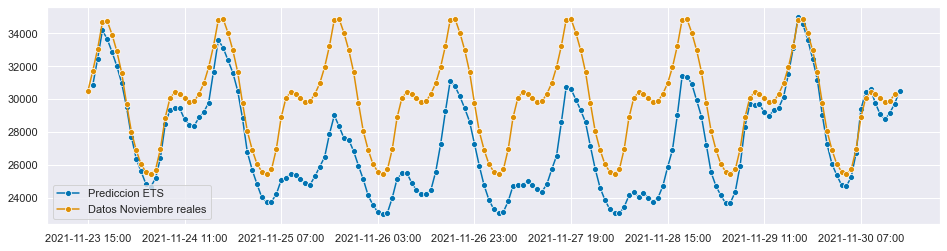

In [194]:
plot_series(y_test, ETS_pred, labels=[ "Prediccion ETS", "Datos Noviembre reales"])

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

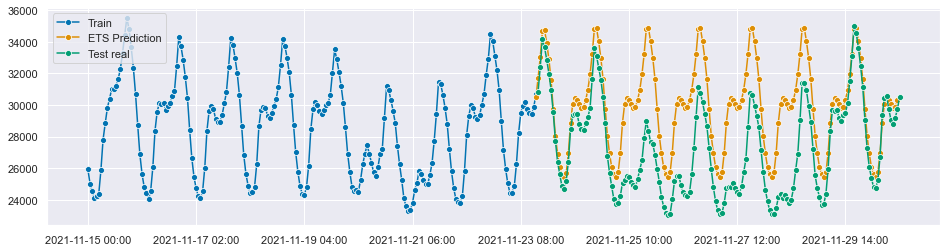

In [195]:
plot_series(y_train['2021-11-15':], ETS_pred, y_test, labels=["Train", "ETS Prediction", "Test real"])

In [196]:
# Forecast Accuracy
# MAPE
ETS_mape = mean_absolute_percentage_error(y_test, ETS_pred)
ETS_mape

0.10111718765900758

In [197]:
# Forecast Accuracy
# Mean Squared Error
rmse = MeanSquaredError(square_root=True)
ETS_rmse = rmse(y_test, ETS_pred)
ETS_rmse

3367.4508087992845

### Modelo ARIMA

Este metodo es similar a una regresion estadistica pero aplicando los conceptos de las series de tiempo; por tanto, los pronosticos del modelo vienen explicados por los datos del pasado obviamente ya que no poseemos ninguna variable exógena que nos ayude a la hora de predecir, además de que somos conscientes de la estacionaridad y estacionalidad de nuestra serie a lo largo del tiempo.

El horizonte de prediccion del modelo es principalmente a corto plazo, teniendo en cuenta esto estudiaremos las predicciones que nos arroje el algoritmo.


In [198]:
# Auto ARIMA Model

autoARIMA_model = AutoARIMA(sp=24, suppress_warnings=True)
autoARIMA_model.fit(y_train)

AutoARIMA(sp=24, suppress_warnings=True)

In [199]:
print(autoARIMA_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  544
Model:             SARIMAX(1, 0, 2)x(1, 0, 2, 24)   Log Likelihood               -4012.818
Date:                            Fri, 21 Jan 2022   AIC                           8041.636
Time:                                    13:30:19   BIC                           8076.028
Sample:                                         0   HQIC                          8055.082
                                            - 544                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1445.4053    305.538      4.731      0.000     846.562    2044.249
ar.L1          0.8166      0.022   

In [200]:
# Auto ARIMA Forecast
Arima_pred = autoARIMA_model.predict(fh)
Arima_pred

C:\Users\moise\.conda\envs\Series_prophet\lib\site-packages\pmdarima\arima\arima.py:692: UserWarning:

As of version 1.5.0 'typ' is no longer a valid arg for predict. In future versions this will raise a TypeError.



,Demand
2021-11-23 15:00,30314.436697
2021-11-23 16:00,31798.157327
2021-11-23 17:00,32550.800063
2021-11-23 18:00,33569.126118
2021-11-23 19:00,33180.753877
...,...
2021-11-30 10:00,29369.789322
2021-11-30 11:00,29313.526418
2021-11-30 12:00,29286.626309
2021-11-30 13:00,29279.168135


In [201]:
# Forecast Accuracy
# MAPE 
# Orignal Time Serie

mean_absolute_percentage_error(y_test , Arima_pred)

0.09615072412869052

In [202]:
# Forecast Accuracy
#Mean Squared Error
rmse = MeanSquaredError(square_root=True)
rmse(y_test, Arima_pred)

3169.9126976589305

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

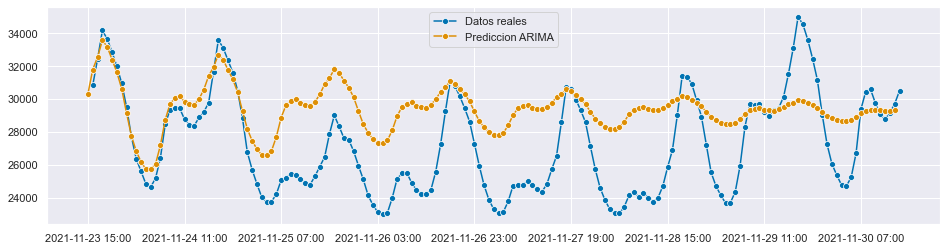

In [222]:
plot_series(y_test, Arima_pred, labels=["Datos reales", "Prediccion ARIMA"])

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

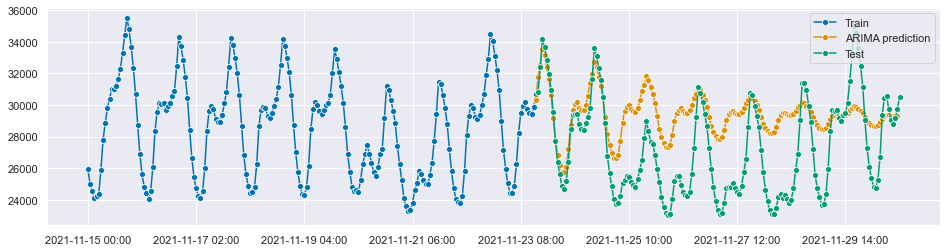

In [204]:
plot_series(y_train["2021-11-15":], Arima_pred, y_test, labels=["Train", "ARIMA prediction", "Test"])

Graficamos las 2 predicciones anteriores junto con el test para ver la diferencia entre ambas respecto a los datos reales.

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

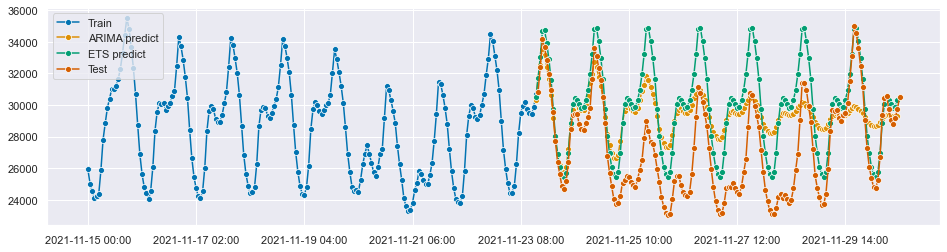

In [205]:
plot_series(y_train["2021-11-15":], Arima_pred, ETS_pred, y_test, labels=["Train", "ARIMA predict", "ETS predict", "Test"])

### Modelo Prophet

Basado en un modelo aditivo donde las tendencias no lineales son ajustadas anualmente semanalmente y diariamente para ver la estacionalidad. Funciona muy bien con series temporales con efectos estacionales, maneja muy bien los outliers.

Preparamos los datos en el formato que necesita el modelo Prophet.

In [206]:
# Train 
prophet_y_train = y_train.copy()
prophet_y_train = prophet_y_train.rename_axis('index').reset_index()
prophet_y_train.columns = ['ds', 'y']
prophet_y_train['ds'] = prophet_y_train['ds'].dt.to_timestamp(freq = 'H')
len(prophet_y_train)

544

In [207]:
# Test
prophet_y_test = y_test.copy()
prophet_y_test = prophet_y_test.rename_axis('index').reset_index()
prophet_y_test.columns = ['ds', 'y']
prophet_y_test['ds'] = prophet_y_test['ds'].dt.to_timestamp(freq = 'H')
len(prophet_y_test)

168

In [208]:
m = Prophet(yearly_seasonality=False)
m.fit(prophet_y_train)

In [209]:
m_pred = m.make_future_dataframe(periods=169, freq='H')
prophet_forecast = m.predict(m_pred)

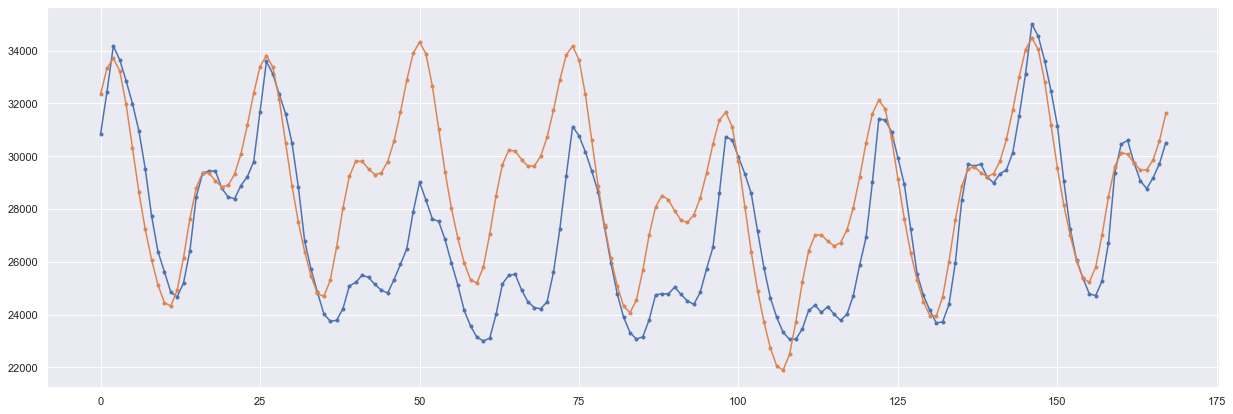

In [210]:
plt.plot(list(prophet_y_test['y']), '.-')
plt.plot(list(prophet_forecast.loc[545:, 'yhat']), '.-')
plt.show()

In [211]:
# Forecast Accuracy
# MAPE
MAPE_prophet = mean_absolute_percentage_error(prophet_y_test['y'], prophet_forecast.loc[545:, 'yhat'])
MAPE_prophet

0.07158179580358259

In [212]:
# Forecast Accuracy
#Mean Squared Error
rmse = MeanSquaredError(square_root=True)
rmse_prophet = rmse(prophet_y_test['y'], prophet_forecast.loc[545:, 'yhat'])
rmse_prophet

2610.0636631639723

## Comparacion de modelos

In [213]:
comparacion = {'Errores': ['MAPE','% MAPE', 'RMSE'],
               'ETS': ['0.09493', '9.493%', '3292.640'],
               'ARIMA': ['0.07909','7.909%', '40747.791'],
               'Prophet': ['0.07158', '7.158%', '2610.063']}

df_comparacion = pd.DataFrame(comparacion)
df_comparacion

,Errores,ETS,ARIMA,Prophet
0,MAPE,0.09493,0.07909,0.07158
1,% MAPE,9.493%,7.909%,7.158%
2,RMSE,3292.640,40747.791,2610.063


## Eleccion del modelo

Nos quedamos con el modelo Prophet ya que es el que menor error tiene en la prediccion, descartando el modelo ARIMA y ETS.

Ahora tendremos que volver a preparar los datos para introducirlos en el modelo Prophet en el formato que necesita.

In [214]:
frames = [prophet_y_train, prophet_y_test]
prophet_original_serie = pd.concat(frames)
len(prophet_original_serie)

712

In [215]:
m = Prophet(yearly_seasonality=False)
m.fit(prophet_original_serie)

In [216]:
prophet_dec = m.make_future_dataframe(periods=177, freq='H')
prophet_forecast_dec = m.predict(prophet_dec)

In [217]:
prophet_forecast_dec = prophet_forecast_dec[712:]

In [218]:
prophet_forecast_dec = prophet_forecast_dec[['ds', 'yhat']]
prophet_forecast_dec = prophet_forecast_dec.set_index('ds')
prophet_forecast_dec

,yhat
ds,
2021-11-30 16:00:00,30747.834539
2021-11-30 17:00:00,31987.209543
2021-11-30 18:00:00,33002.341655
2021-11-30 19:00:00,33388.720449
2021-11-30 20:00:00,32922.475792
...,...
2021-12-07 20:00:00,33783.666565
2021-12-07 21:00:00,32569.681124
2021-12-07 22:00:00,30976.669345


Indexamos la fecha para poder graficar la predicción con la serie original.

In [219]:
prophet_original_serie = prophet_original_serie.set_index('ds')

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

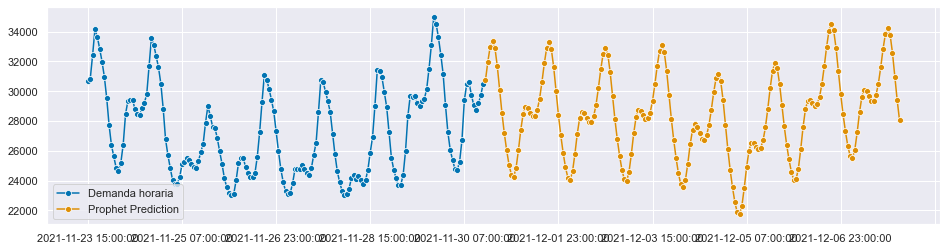

In [220]:
plot_series(prophet_original_serie[543:], prophet_forecast_dec['yhat'], labels=["Demanda horaria", "Prophet Prediction"])

Esta es la prediccion que obtenermos de la demanda electrica de los 7 primeros dias de Diciembre. Dentro de los 3 modelos que hemos usado, el modelo Prophet es el que mejor se adapta a los datos.

### Exportamos los resultados

In [223]:
df = pd.DataFrame(prophet_forecast_dec) 
df.to_csv('Prediccion_horaria.csv')